In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage import exposure
import glob
#show matplot images inline
%matplotlib inline

# Get images

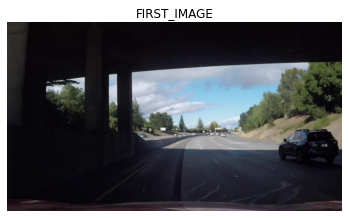

In [21]:
def show_image(image,title="image",cmap_type="gray"):
    plt.imshow(image,cmap_type)
    plt.title(title)
    plt.axis("off")
#LOADING ALL IMAGES FROM TEST_IMAGES FILE
images = glob.glob("test_images/*.jpg")
images = [plt.imread(image) for image in images] 

show_image(images[0],"FIRST_IMAGE")

# Helper Functions

In [22]:
##ZIAD 
def gaussian_blur(img,kernel_size):
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),#5x5 I guess
                  0)
def pipeline(img):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
#     s_channel = hls[:,:,2]
#     h_channel = hls[:,:,0]
#     v_channel= hsv[:,:,2]
    return l_channel

In [23]:
##Omar
def perspective_transform(img,dst_size=(1280,720),inv=0):
    img_size=np.float32([(img.shape[1],img.shape[0])])
    #Region of Interest
    #Order is top left, top right, bottom left, bottom right
    src=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])
    dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])
    srcPoints = src*img_size
    dstPoints = dst*np.float32(dst_size)
    if(inv):
        M = cv2.getPerspectiveTransform(dstPoints,srcPoints) #inverse
    else:
        M = cv2.getPerspectiveTransform(srcPoints,dstPoints) #Returns a matrix that transforms an Image
    warped_image = cv2.warpPerspective(img,M,dst_size)
    return warped_image 
# Histogram Equalizer
def hist_equalizer(img):
    pass

In [24]:
##Fady
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist
def filter_lane_lines(img):
    img = gaussian_blur(img,5)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(27,27))
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    mask = np.zeros_like(tophat)
#     mask[((tophat > 10)&(tophat<=150))] = 1 #Thresholding
    mask = cv2.threshold(tophat, 10, 255, cv2.THRESH_BINARY)[1]
    kernel = np.ones((13,13),np.uint8)
    mask = cv2.dilate(mask,kernel,iterations = 1)
    kernel = np.ones((10,5),np.uint8)
    mask = cv2.erode(mask,kernel,iterations = 1)
    return mask

Text(0.5, 1.0, 'filtered lane')

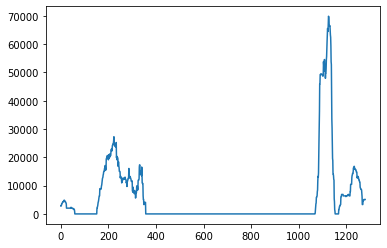

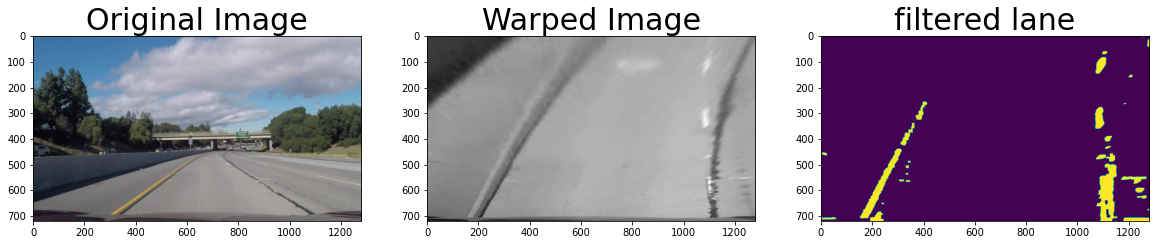

In [27]:
img = images[2]
# img = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
img1 = pipeline(img)
warped_image = perspective_transform(img1, dst_size=(1280,720),inv=0)
filtered_lane = filter_lane_lines(warped_image)
histogram = get_hist(filtered_lane)
# show_image(mask)
plt.plot(histogram)
# plotting
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)
ax3.imshow(filtered_lane)
ax3.set_title('filtered lane', fontsize=30)


# Sliding Window

In [59]:
#Globally defined to store the parameters of past images
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, 
                   nwindows=9, #Number of windows 
                   margin=100, #half window width 100?
                   minpix = 50 #minimum number of pixels to recenter the window 50? 
                  ):
    global left_a, left_b, left_c,right_a, right_b, right_c  # hn3raf ba3den
    left_fit_= np.empty(3) #parameters of 2nd order polynomial
    right_fit_ = np.empty(3) 
    out_img = np.dstack((img, img, img))*255 #Converts binary to 3 dimensional channel normal RGB
    
    #USING HISTOGRAM METHOD
    histogram = get_hist(img) 
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int_(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # Indices in image is the coordinates the row is the height is the y
    # the column is the width is the x
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        
        #Get non-zero pixels within each window by getting the indices of nonzerox
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0] 
        #[0] get indices of nonzerox only but you can access nonzeroy with it too
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        ''' 
        minpix is used to recenter the window and depends on how good the filter is
        if minpix is low it might be affected by the noise(?)
        therefore we keep minpix at 50 pixels for now to only recenter in the direction of any solid line
        '''
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int_(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int_(np.mean(nonzerox[good_right_inds]))
        

    # Concatenate the arrays of indices
    #All pixels within all 9 windows
    left_lane_inds = np.concatenate(left_lane_inds) 
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    #All x and y coordinates for pixels residing inside the 9 windows
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    #Returns three parameters 
    left_fit = np.polyfit(lefty, leftx,
                          2 #Order of the equation
                         )
    right_fit = np.polyfit(righty, rightx, 2)
    
    #ay^2+by+c
    #store these three parameters
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    #find the mean for the last 10 frames
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting the two curves
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] ) #the points that will be on the y-axis
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2] 
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]
    
    #Coloring the pixels within the windows
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100] #Red
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255] #Blue
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

def draw_lanes(img, left_fit, right_fit,ploty):
#     ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    #Horizontal stack #dstack = depth stack #vstack = vertical stack
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))]) #flip up to down
    points = np.hstack((left, right)) 
    #Draw two curved lines
    cv2.polylines(color_img, np.int_(left) , False, (255,0,0),20) #Red curved line
    cv2.polylines(color_img, np.int_(right), False, (0,0,255),20) #Blue curved line
    #Draw a polygon of the curve shape
    cv2.fillPoly(color_img, np.int_(points), (0,255,0)) #Green curve
    inv_perspective = perspective_transform(color_img,inv=1)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective,color_img


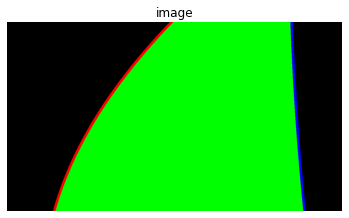

In [60]:
#%matplotlib gtk
out_img, curves, lanes, ploty = sliding_window(filtered_lane)
img_,birdview_curve = draw_lanes(img, curves[0], curves[1],ploty)
plt.imshow(img_, cmap='hsv')
show_image(birdview_curve)

NameError: name 'dst' is not defined

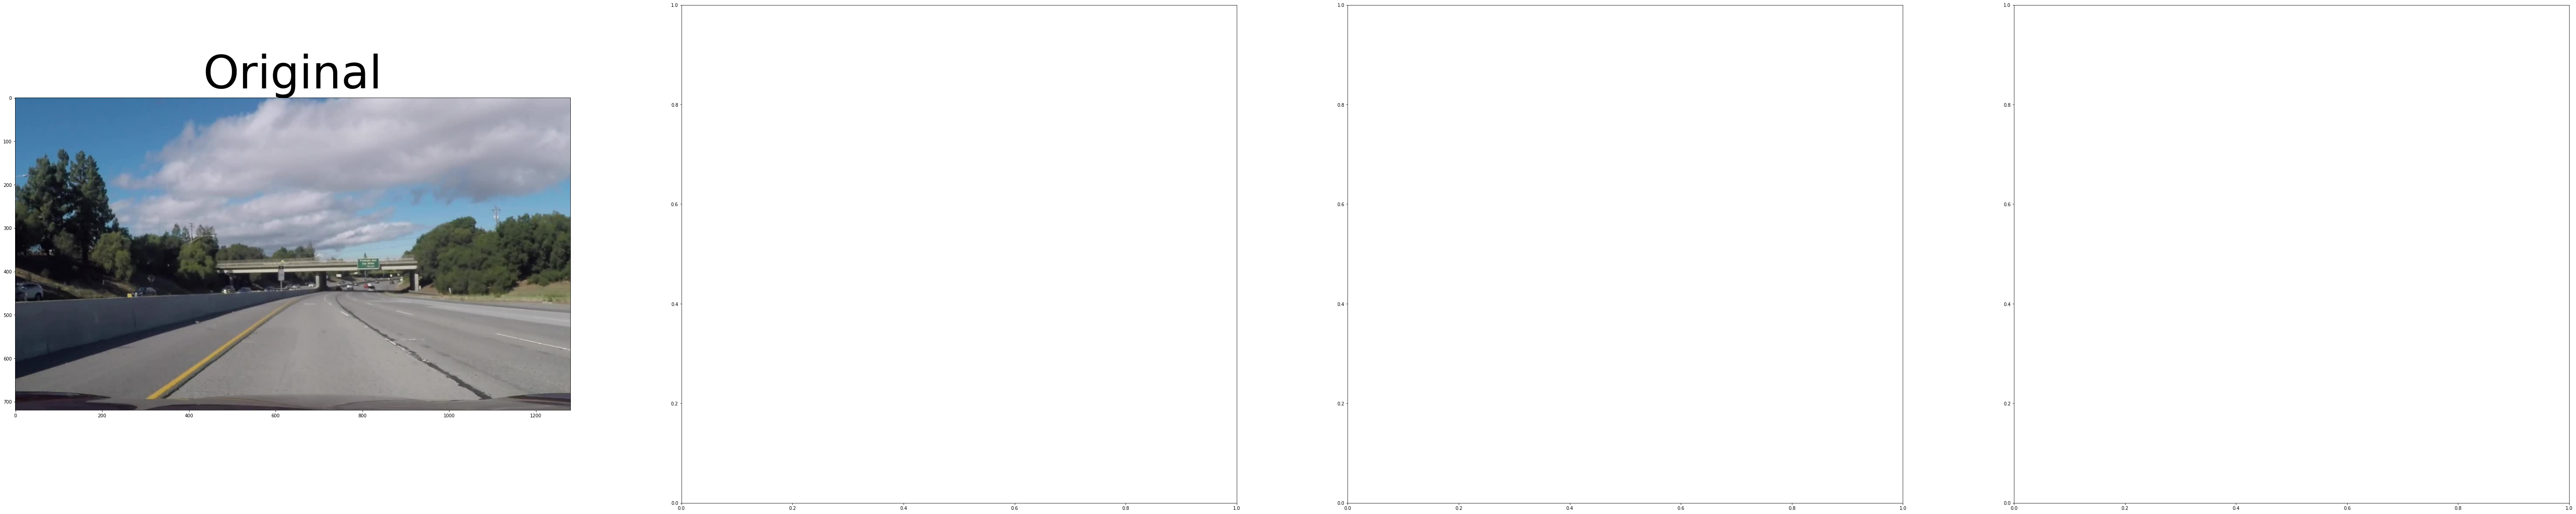

In [61]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(100, 20))
#f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=100)
ax2.imshow(filtered_lane)
ax2.set_title('Filter+Perspective Tform', fontsize=100)
ax3.imshow(out_img)
ax3.plot(curves[0], ploty, color='yellow', linewidth=30)
ax3.plot(curves[1], ploty, color='yellow', linewidth=30)
ax3.set_title('Sliding window+Curve Fit', fontsize=100)
ax4.imshow(img_)
ax4.set_title('Overlay Lanes', fontsize=100)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)